In [48]:
import matplotlib
import math
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import r2_score

In [49]:
df = pd.read_csv('data1008_1_train.csv',encoding="cp1252")
x = torch.tensor(df.iloc[:,1:-1].to_numpy()).to(torch.float32)
y = torch.tensor(df.iloc[:,-1].to_numpy()).to(torch.float32)
x.shape

torch.Size([2146, 168])

In [50]:
class stockDataSetter(Dataset):
    def __init__(self, x, y=None):
        if y is None:
            self.y = y
        else:
            self.y = torch.FloatTensor(y)
        self.x = torch.FloatTensor(x)

    def __getitem__(self, idx):
        if self.y is None:
            return self.x[idx]
        else:
            return self.x[idx], self.y[idx]
    
    def __len__(self):
        return len(self.x)

In [51]:
Batchsize = x.shape[0]//10
train_set = stockDataSetter(x, y)
train_loader = DataLoader(train_set, Batchsize,shuffle=True, pin_memory=True)

In [52]:
import torch
import torch.nn.functional as F   

class My_model(torch.nn.Module): 
    def __init__(self, input_dim):
        super(My_model, self).__init__()
        self.layers = torch.nn.Sequential(
            nn.Linear(input_dim, 164),
            nn.ReLU(),
            nn.Linear(164, 1)
        )
        
    def forward(self, x):
        x = self.layers(x)
        x = x.squeeze(1)
        return x

net = My_model(input_dim=x.shape[1])
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
# optimizer = torch.optim.RAdam(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-5, weight_decay=0, foreach=True)
optimizer = torch.optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False, foreach=None, maximize=False, capturable=False)
loss_function = torch.nn.MSELoss(reduction='mean')

print(net)  # net 的结构

My_model(
  (layers): Sequential(
    (0): Linear(in_features=168, out_features=164, bias=True)
    (1): ReLU()
    (2): Linear(in_features=164, out_features=1, bias=True)
  )
)


In [53]:
#訓練
checkpoint = torch.load('model_state_dict.pt')
net.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']
net = net.train()


best_loss = math.inf
patience = 0
for t in range(1000000):
    
    x, y = next(iter(train_loader))
    
    prediction = net(x).to(device)
    loss = loss_function(prediction,y).to(device)
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    
    if loss<best_loss:
        patience = 0
        best_loss = loss
        torch.save(net, 'Save_File10072230.pth')
        torch.save({
            'epoch': t,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss
            }, 'model_state_dict.pt')
    else:
        patience += 1
    
    if patience >= 5000:
        print('loss已經訓練5000次未下降')
        break

    
    # 接着上面来
    if t % 50 == 0:
        # plot and show learning process
        print('================================================')
        # print('pred: ',prediction.data.numpy())
        # print('y: ', y.data.numpy())
        print('loss: ',loss.data.numpy())
        print('best_loss: ',best_loss.data.numpy(),f'    第:{t}輪')
        print('================================================')      

loss:  506.26837
best_loss:  506.26837     第:0輪
loss:  394.53607
best_loss:  239.30507     第:50輪
loss:  1096.3186
best_loss:  202.47119     第:100輪
loss:  639.9632
best_loss:  186.84679     第:150輪
loss:  132.12003
best_loss:  132.12003     第:200輪
loss:  515.0922
best_loss:  132.12003     第:250輪
loss:  270.54462
best_loss:  120.101456     第:300輪
loss:  322.96805
best_loss:  120.101456     第:350輪
loss:  186.64194
best_loss:  114.90635     第:400輪
loss:  2355.55
best_loss:  104.51119     第:450輪
loss:  1329.5947
best_loss:  104.51119     第:500輪
loss:  307.6105
best_loss:  104.51119     第:550輪
loss:  335.8302
best_loss:  104.51119     第:600輪
loss:  231.67023
best_loss:  104.51119     第:650輪
loss:  606.3223
best_loss:  104.405426     第:700輪
loss:  4951.4697
best_loss:  104.405426     第:750輪
loss:  704.16693
best_loss:  104.405426     第:800輪
loss:  1246.3029
best_loss:  104.405426     第:850輪
loss:  516.3614
best_loss:  104.405426     第:900輪
loss:  1023.0658
best_loss:  104.405426     第:950輪
los

In [56]:
#檢查
checkpoint = torch.load('model_state_dict.pt')
net.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']
net = net.eval()

prediction = net(x).to(device)
loss = loss_function(prediction,y).to(device)

pred,actual = pd.DataFrame(prediction.data.numpy()), pd.DataFrame(y.data.numpy())
compare = pd.DataFrame(columns=['actual','predict'])
compare['actual'],compare['predict'] = y.data.numpy(), prediction.data.numpy()
compare = compare.T

loss:  1249.6653


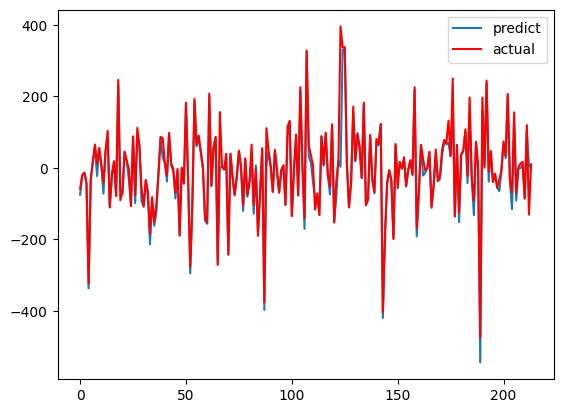

,0,1,2,3,4,5,6,7,8,9,...,204,205,206,207,208,209,210,211,212,213
actual,-58.390621,-19.969727,-13.410160,-41.709961,-324.209961,-33.149414,19.169922,65.169922,11.73047,56.159668,...,-67.880859,155.110352,-69.490234,1.050782,12.020500,17.040039,-84.700195,119.830078,-130.839844,9.509766
predict,-75.138359,-20.792137,-13.504418,-42.472008,-336.865570,-33.012566,17.534706,59.181740,-22.64814,53.397438,...,-115.624535,121.033264,-91.508080,-0.903405,-0.961049,8.576697,-86.712791,107.350792,3.088233,9.047584


In [58]:
ax = plt.gca()
print('loss: ',loss.data.numpy())
compare.T.plot(kind='line',y ='predict',ax=ax)
compare.T.plot(kind='line',y ='actual',ax=ax,color='red')
plt.show()
compare
# Display all model layer weights
# for name, para in net.named_parameters():
#     print('{}: {}'.format(name, para.shape))

In [335]:
r2_score(compare.T['actual'],compare.T['predict'])

0.9293536791687844